# DLthon - 길찾는 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf
from keras import layers

# keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import models_base, models_top, utils

2025-01-22 20:25:54.898988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 20:25:54.935540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737545154.955928  396063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737545154.962424  396063 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 20:25:55.003058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_datasets("data_no_aug")

Found 319 files belonging to 6 classes.


I0000 00:00:1737545157.656645  396063 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.


## Model Design

In [3]:
# designing the model

def eV2L_midsize3(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = utils.image_preprocessing_v1()(inputs)
    x = models_base.EV2L((224, 224, 3))(x, training=False)
    x = models_top.midsize3()(x)
    outputs = layers.Dense(6, activation='softmax', name="classifier")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                   metrics=['accuracy'])
    
    return model

eV2L_midsize3().summary()

KeyboardInterrupt: 

Epoch 1/200


I0000 00:00:1737356495.401517  344527 cuda_dnn.cc:529] Loaded cuDNN version 90600


5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1997 - loss: 1.8018 - val_accuracy: 0.3333 - val_loss: 1.7708
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - accuracy: 0.2102 - loss: 1.7742 - val_accuracy: 0.4103 - val_loss: 1.7568
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.3063 - loss: 1.7426 - val_accuracy: 0.3590 - val_loss: 1.7459
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.2783 - loss: 1.7301 - val_accuracy: 0.3590 - val_loss: 1.7349
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.3223 - loss: 1.7158 - val_accuracy: 0.3590 - val_loss: 1.7228
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.2614 - loss: 1.7147 - val_accuracy: 0.3590 - val_loss: 1.7112
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - accuracy: 0.3765 - loss: 1.6830 - val_accuracy: 0.4359 - val_loss: 1.6993
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.3564 - loss: 1.6895 - val_accuracy: 0.4103 - val_loss: 1.683

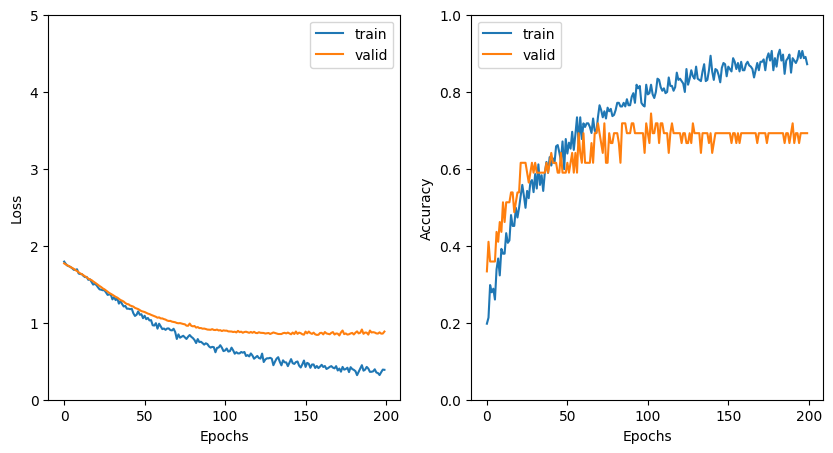

In [6]:
eV2L_midsize3_history = eV2L_midsize3().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_midsize3.keras'),
        utils.callback_earlystop(30)
    ],
)
utils.plot_history(eV2L_midsize3_history)

In [7]:
test_loss, test_acc = keras.models.load_model('eV2L_midsize3.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8250 - loss: 0.6606
Test accuracy: 0.82%, Test loss: 0.66
